In [1]:
import numpy as np
import skimage as ski
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, data
import cv2
from PIL import Image
import scipy.misc
import math
import skimage.morphology as morph
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
import bisect

C:\Users\naresh\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [4]:
#filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\IMG_0470.JPG"
#filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\8-3-23 - Warm 0.75 Frost.JPG"
#filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\IMG_0468.JPG"
filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\8-3-23 - White Full Frost.JPG"
#filename = "W:\Advanced Engineering/Vortex Ballistics/Gel Images/NR Image.JPG"
#filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\9-7-23\IMG_0489.JPG"
#filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\9-7-23\IMG_0491.JPG"
#filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\9-7-23\IMG_0493.JPG"
#filename = "W:\Advanced Engineering\Vortex Ballistics\Gel Images\9-7-23\IMG_0495.JPG"
gelImg = cv2.imread(filename)
fixLength = 34 #Dimension in x-axis
fixHeight = 30 #Dimension in y-axis
dimDiff = fixLength-fixHeight

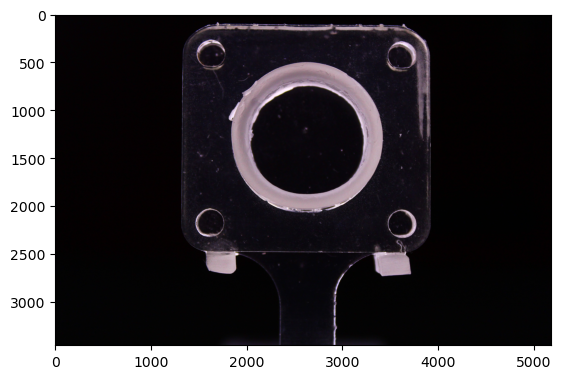

In [5]:
gelImg = cv2.cvtColor(gelImg, cv2.COLOR_BGR2RGB)
plt.imshow(gelImg)
plt.show()

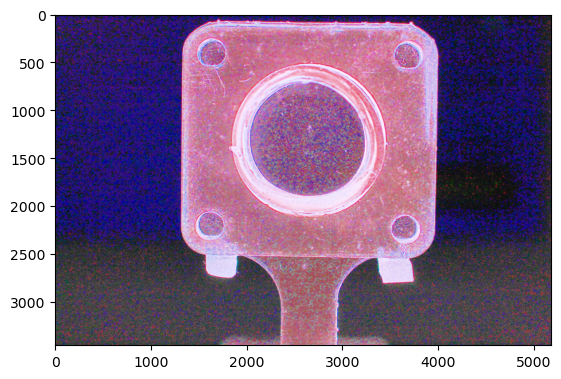

In [61]:
gelHSV = cv2.cvtColor(gelImg, cv2.COLOR_BGR2HSV)
gelHSV[:,:,2] = cv2.equalizeHist(gelHSV[:,:,2])
hsvDisp = cv2.cvtColor(gelHSV,cv2.COLOR_HSV2RGB)
plt.imshow(hsvDisp)

In [62]:
gelImgGray = cv2.cvtColor(gelImg, cv2.COLOR_BGR2GRAY)

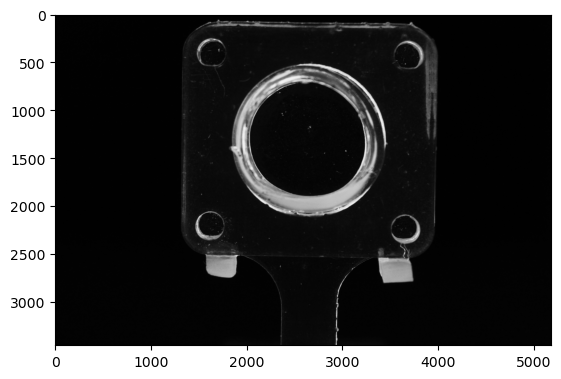

In [63]:
plt.imshow(gelImgGray, cmap='gray')
plt.show()

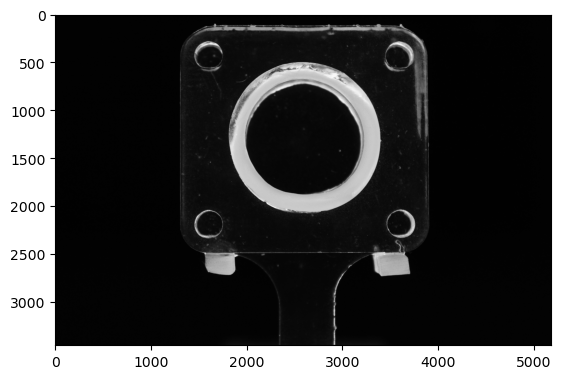

In [560]:
# Grayscale, Otsu's threshold, opening
image = cv2.imread(filename)
#image = cv2.medianBlur(image,3)
blank_mask = np.zeros(image.shape, dtype=np.uint8)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

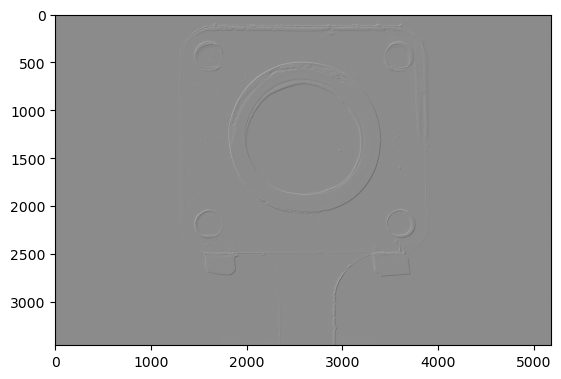

In [604]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
blended = cv2.addWeighted(sobelx, .5, sobely, .5, 0)
blendGam = np.power(blended, 9)
plt.imshow(blended, cmap= 'gray')

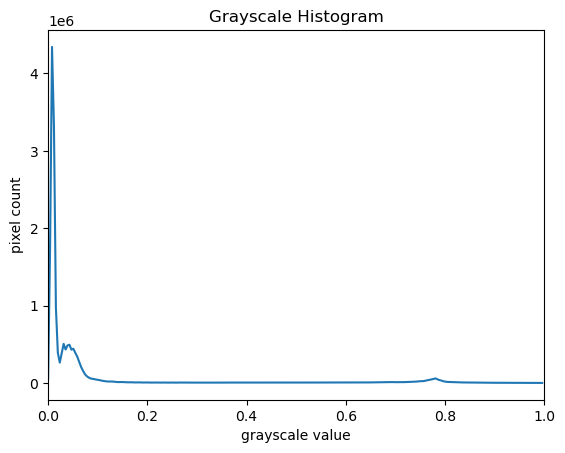

In [561]:
histoGray = ski.util.img_as_float(gray)

histogram, bin_edges = np.histogram(histoGray, bins=256, range=(0, 1))
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here

In [562]:
print((histogram))

[  59482 1763964 4343138 3309277  972629  388998  262590  385085  505079
  431723  484724  493170  429805  442102  389515  340469  274341  207078
  156773  112841   85579   68606   57354   53124   47662   43204   38447
   33656   27809   23616   19809   18350   18886   18348   16038   12437
   10560   11410   11783   10023    7915    7906    8748    8266    6541
    6143    7032    6934    5673    5137    5713    5997    5135    4422
    5025    5406    4936    4087    4393    5107    4773    4107    4077
    4769    4718    4164    3873    4595    4885    4487    3927    4025
    4442    4743    4497    4089    3885    4084    4542    4322    4093
    3888    3972    4242    4558    4573    4330    4037    3655    3554
    4091    4521    4755    4760    4671    4648    4147    3545    3540
    3999    4388    4655    4725    4538    4259    3999    3613    3553
    3726    3970    3965    4064    4001    4010    3834    3555    3459
    3567    3577    3640    3807    3781    3922   

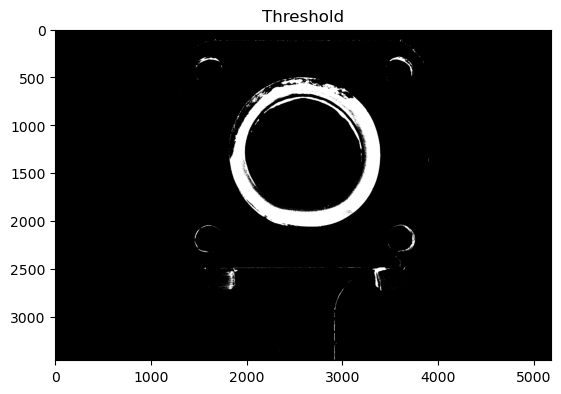

In [598]:
#thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1]
#thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
#thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)[1]
histoCum = np.cumsum(histogram)
index80 = bisect.bisect_right(histoCum, .96*histoCum[-1])

thresh = cv2.threshold(gray, index80, 255, cv2.THRESH_BINARY)[1]
thresh1 = cv2.adaptiveThreshold(gray, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 301,8)

plt.imshow(thresh, cmap='gray')
plt.title("Threshold")
plt.show()


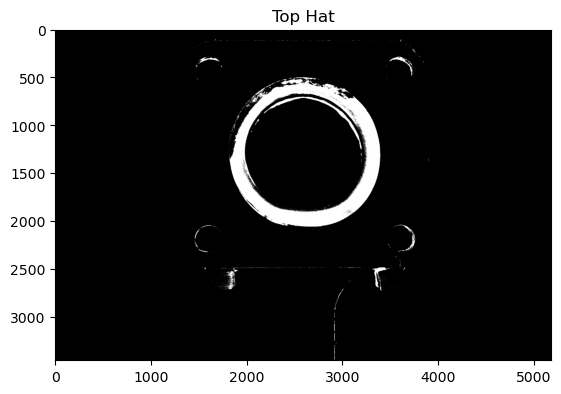

In [575]:
kernelTop = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30,30))
topHat = cv2.morphologyEx(thresh, cv2.MORPH_TOPHAT, kernelTop, iterations = 3)
topHat = thresh + topHat

plt.imshow(topHat, cmap='gray')
plt.title("Top Hat")
plt.show()

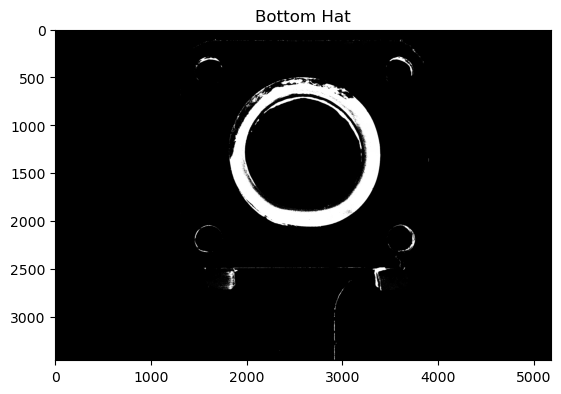

In [576]:
kernelBot = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13,13))
botHat = cv2.morphologyEx(topHat, cv2.MORPH_BLACKHAT, kernelBot, iterations = 3)
botHat = topHat-botHat

plt.imshow(botHat, cmap='gray')
plt.title("Bottom Hat")
plt.show()

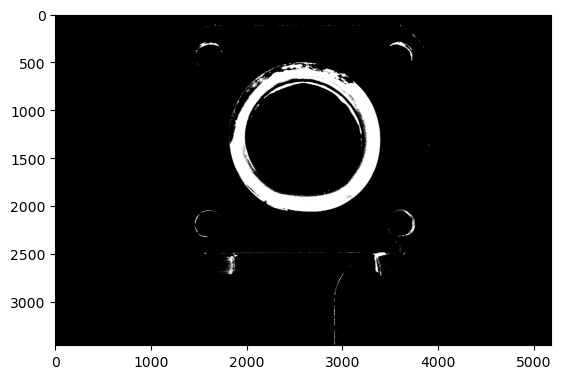

In [577]:
ret, sure_fg = cv2.threshold(botHat, 0.7 * botHat.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)  
plt.imshow(sure_fg, cmap='gray')
plt.show()

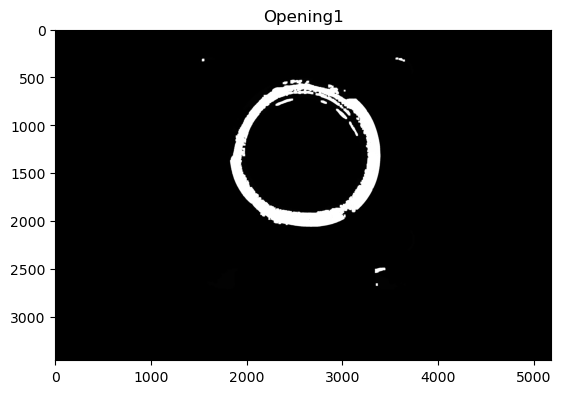

In [578]:
#cv2.opening using a rectangular kernel
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
opening1 = cv2.morphologyEx(botHat, cv2.MORPH_OPEN, kernel1, iterations=2)

plt.imshow(opening1, cmap='gray')
plt.title("Opening1")
plt.show()

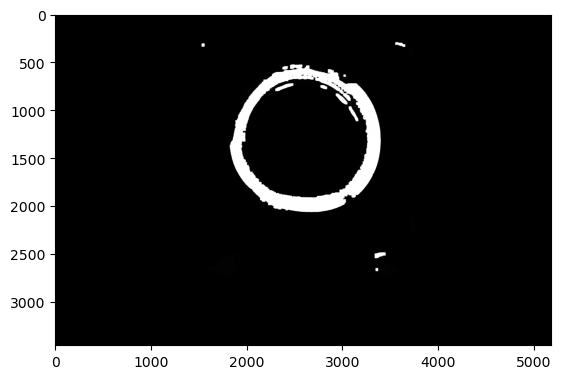

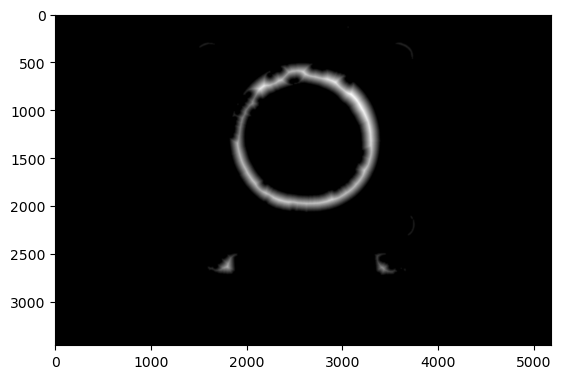

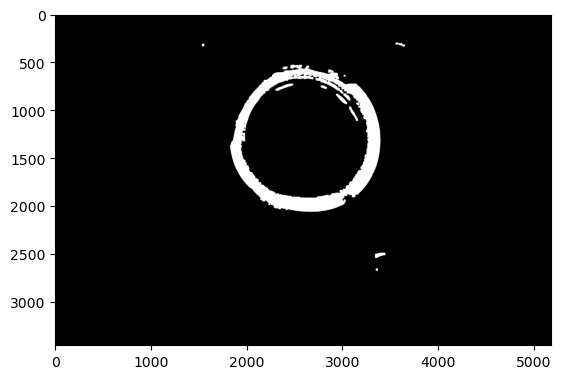

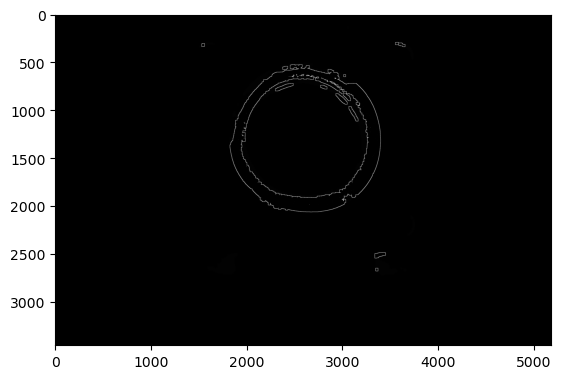

In [579]:
imgProcess = opening1

# Create subplots with 1 row and 2 columns
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
# sure background area
sure_bg = cv2.dilate(imgProcess, kernel, iterations=3)
plt.imshow(sure_bg, cmap='gray')
plt.show()
  
# Distance transform
dist = cv2.distanceTransform(imgProcess, cv2.DIST_L2, 5)
plt.imshow(dist, cmap='gray')
plt.show()
  
#foreground area
ret, sure_fg = cv2.threshold(imgProcess, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)  
plt.imshow(sure_fg, cmap='gray')
plt.show()
  
# unknown area
unknown = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown, cmap='gray')
  
plt.show()

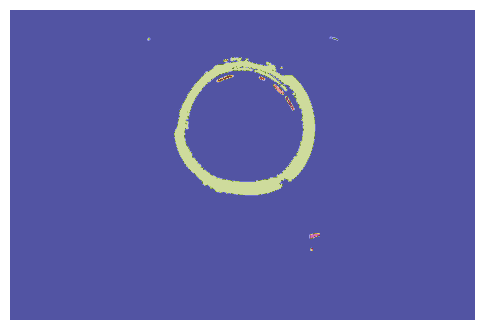

In [580]:
# Marker labelling
# sure foreground 
ret, markers = cv2.connectedComponents(sure_fg)
  
# Add one to all labels so that background is not 0, but 1
markers += 1
# mark the region of unknown with zero
markers[unknown == 255] = 0
  
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()

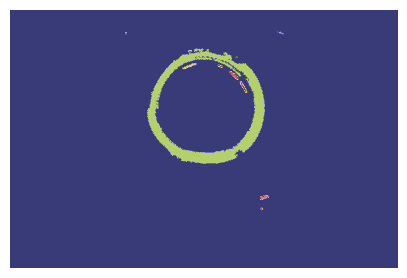

[]


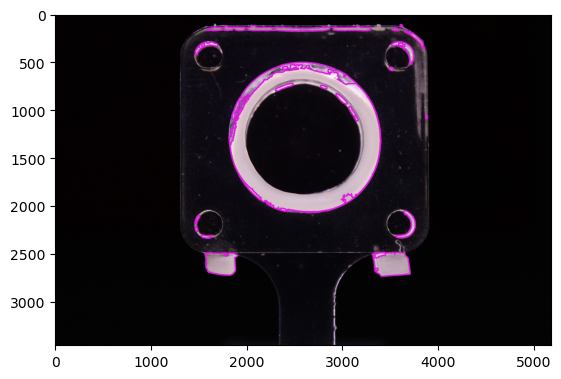

In [581]:
# watershed Algorithm
markers = watershed(opening1, markers)
  
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(markers, cmap="tab20b")
ax.axis('off')
plt.show()
  
    
labels = np.unique(markers)
  
coins = []
print(coins)
for label in labels[2:]: 
    
# Create a binary image in which only the area of the label is in the foreground 
#and the rest of the image is in the background   
    target = np.where(markers == label, 255, 0).astype(np.uint8)
    
  # Perform contour extraction on the created binary image
    contours, hierarchy = cv2.findContours(
        target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    coins.append(contours[0])
    
# Draw the outline
img = cv2.drawContours(gelImg, coins, -1, color=(223, 23, 223), thickness=13)
plt.imshow(img)

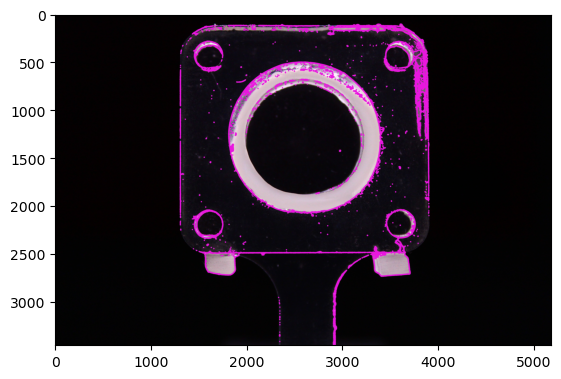

In [347]:
img = cv2.drawContours(gelImg, coins, -1, color=(233, 23, 223), thickness=13)
plt.imshow(img)

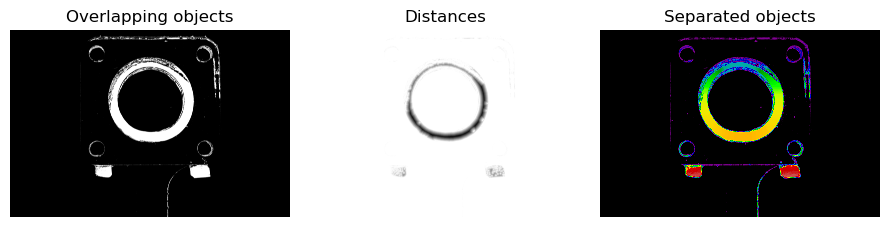

In [307]:
watershedImg = thresh2
distance = ndi.distance_transform_edt(watershedImg)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=watershedImg)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=watershedImg)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(watershedImg, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

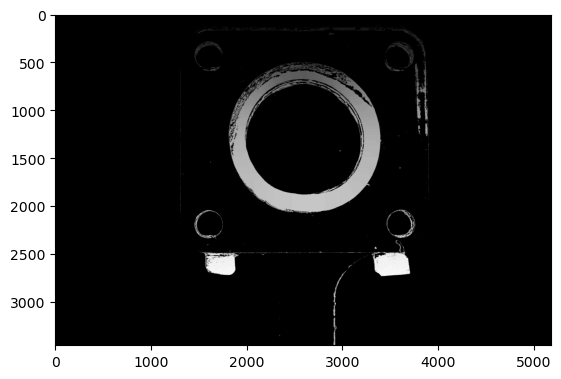

In [267]:
watershedMid = (np.ceil(labels/255)) * 255
plt.imshow(watershedMid, cmap='gray')

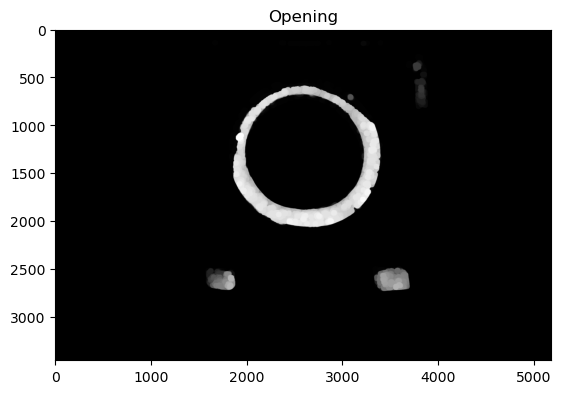

In [288]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
opening = cv2.morphologyEx(thresh2, cv2.MORPH_OPEN, kernel, iterations=4)

plt.imshow(opening, cmap='gray')
plt.title("Opening")
plt.show()

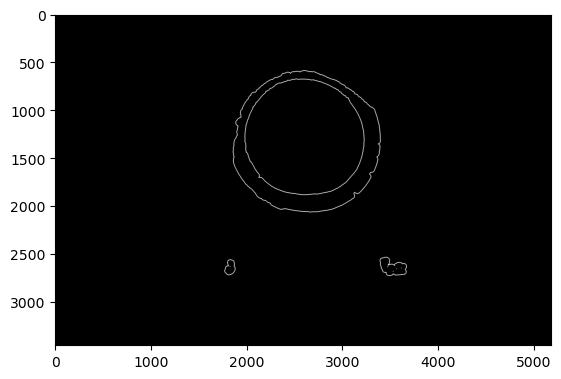

In [269]:
#finalGray = cv2.cvtColor(-distance, cv2.COLOR_BGR2GRAY)
finalGray = np.array((opening), np.uint8)
#finalGray = watershedFin
contours, hierarchy = cv2.findContours(finalGray.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
outlineMid = np.zeros_like(finalGray)
cv2.drawContours(outlineMid, contours, -1, 255, 5)

plt.imshow(outlineMid, cmap='gray')

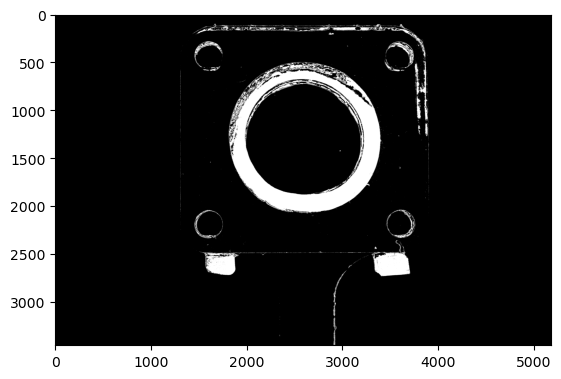

In [259]:
watershedFin = (np.ceil(watershedMid/255)) * 255
plt.imshow(watershedFin, cmap='gray')

In [260]:
# img = cv2.merge([opening,opening,opening])
# #tmp = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# tmp = opening

# # Applying thresholding technique
# _, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)

# # Using cv2.split() to split channels
# # of coloured image
# b, g, r = cv2.split(img)

# # Making list of Red, Green, Blue
# # Channels and alpha
# rgba = [b, g, r, alpha]

# # Using cv2.merge() to merge rgba
# # into a coloured/multi-channeled image
# dst = cv2.merge(rgba, 4)
# dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)

# # percentiles = np.percentile(dst, [0, 25, 75, 100])
# # targets = np.geomspace(10, 255, 4)
# # b = np.interp(dst, percentiles, targets).astype(np.uint8)
# # g = np.zeros_like(dst)
# # r = np.interp(dst, percentiles, targets[::-1]).astype(np.uint8)

# bOVer = []
# gOver = []
# rOver = []
# for row in range(len(dst)):
#     for col in range(len(dst[0])):
#         if dst[row, col] <= 15:
#             b.append(254)
#             g.append(254)
#             r.append(254)
#         else:
#             r.append(254)
#             g.append(0)
#             b.append(0)

# gOver = np.multiply(np.ones((len(gelImg), len(gelImg[0]))), gelImg[:,:,1])
# #g = np.ones((len(image), len(image[0]))) * 254
# # b = (1 - np.ceil(dst/255)) * 254
# # r = (1 - np.ceil(dst/255)) * 254
# bOver = np.multiply((1 - np.ceil(dst/255)), gelImg[:,:,2])
# rOver = np.multiply((1 - np.ceil(dst/255)), gelImg[:,:,0])

gOutlineMid = np.multiply(np.ones((len(gelImg), len(gelImg[0]))), gelImg[:,:,1])
bOutlineMid = np.multiply((1 - np.ceil(outlineMid/255)), gelImg[:,:,2])
rOutlineMid = np.multiply((1 - np.ceil(outlineMid/255)), gelImg[:,:,0])

# gOutlineFin = np.multiply(np.ones((len(gelImg), len(gelImg[0]))), gelImg[:,:,1])
# bOutlineFin = np.multiply((1 - np.ceil(outlineFin/255)), gelImg[:,:,2])
# rOutlineFin = np.multiply((1 - np.ceil(outlineFin/255)), gelImg[:,:,0])

Text(0.5, 1.0, 'Outline of Image after Erosion')

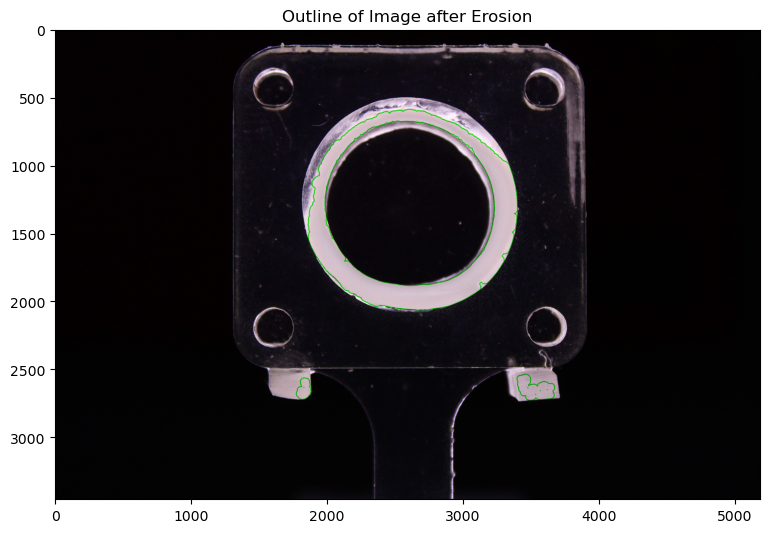

In [261]:
# r = np.reshape(r, (len(image), len(image[0])))
# g = np.reshape(g, (len(image), len(image[0])))
# b = np.reshape(b, (len(image), len(image[0])))
#overlay = np.zeros([len(rOver), len(rOver[0]), 3], dtype=np.uint8)

# overlay = np.zeros([len(rOver), len(rOver[0]), 3], dtype=np.uint8)
# overlay[:,:,0] = rOver
# overlay[:,:,1] = gOver
# overlay[:,:,2] = bOver

outlineMid = np.zeros([len(rOutlineMid), len(rOutlineMid[0]), 3], dtype=np.uint8)
outlineMid[:,:,0] = rOutlineMid
outlineMid[:,:,1] = gOutlineMid
outlineMid[:,:,2] = bOutlineMid

# outlineFin = np.zeros([len(rOutlineFin), len(rOutlineFin[0]), 3], dtype=np.uint8)
# outlineFin[:,:,0] = rOutlineFin
# outlineFin[:,:,1] = gOutlineFin
# outlineFin[:,:,2] = bOutlineFin

fig = plt.figure(figsize=(20, 14))
# fig.add_subplot(2, 2, 1)
# plt.imshow(overlay)
# plt.title("Original Image + Filtered Overlay")
fig.add_subplot(2, 2, 2)
plt.imshow(outlineMid)
plt.title("Outline of Image after Erosion")
# fig.add_subplot(2, 2, 4)
# plt.imshow(outlineFin)
# plt.title("Outline of Image after Final")
# plt.show()

### Graphical Output of Thickness

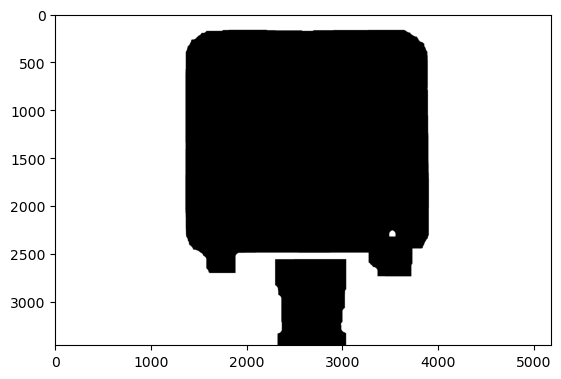

In [262]:
kernelCenter = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))

threshCenter = cv2.threshold(gelImgGray, 0, 255, cv2.THRESH_BINARY_INV)[1]
contours, hierarchy = cv2.findContours(threshCenter.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
fullOutline = np.zeros_like(threshCenter)
cv2.drawContours(fullOutline, contours, -1, 255, 100)
fullOutline = cv2.erode(fullOutline,kernelCenter,iterations = 15)

kernelClose = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
closing = cv2.morphologyEx(fullOutline, cv2.MORPH_CLOSE, kernelClose, iterations = 30)

plt.imshow(closing, cmap='gray')

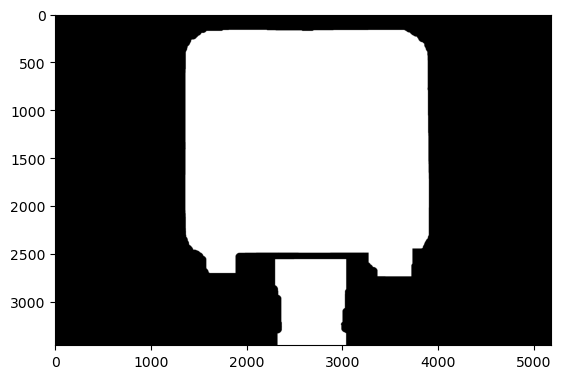

In [263]:
im_th = 255-closing
im_floodfill = im_th.copy()
h,w = im_th.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)

cv2.floodFill(im_floodfill, mask, (0,0), 255);
im_floodfill_inv = cv2.bitwise_not(im_floodfill)
im_out = im_th | im_floodfill_inv

plt.imshow(im_out, cmap='gray')
plt.show()

In [264]:
#Sizing the Image

midLine = im_out[math.ceil(len(im_out)/2), :]
nonZeroInd = np.nonzero(im_out[math.ceil(len(im_out)/2), :])[0]

pixLen = round((nonZeroInd[-1]-nonZeroInd[0])/fixLength)

1558


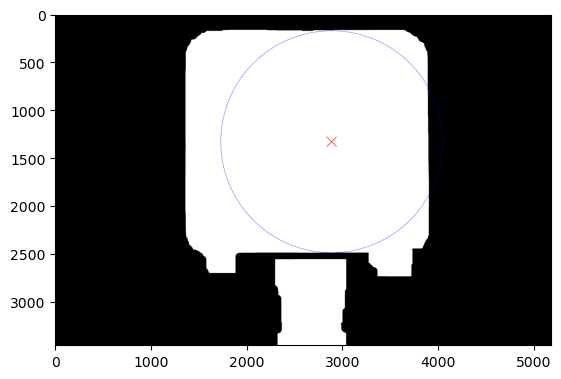

In [265]:
mask = im_out

"""
Get the maximum/largest inscribed circle inside mask/polygon/contours.
Support non-convex/hollow shape
"""
dist_map = cv2.distanceTransform(mask, cv2.DIST_L2, cv2.DIST_MASK_PRECISE)
_, radius, _, center = cv2.minMaxLoc(dist_map)

if dimDiff > 0:
    xCenter = center[0] + round(dimDiff/2*pixLen)
    yCenter = center[1]
else:
    xCenter = center[0]
    yCenter = center[1] + round(dimDiff/2*pixLen)
    
# xCenter = center[0]
# yCenter = center[1]
print(xCenter-yCenter)
    
result = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
cv2.circle(result, (xCenter, yCenter), int(radius), (0, 0, 255), 2, cv2.LINE_8, 0)

centerLength = 50
cv2.line(result, (xCenter-centerLength, yCenter-centerLength), (xCenter+centerLength, yCenter+centerLength), (255,0,0), 5)
cv2.line(result, (xCenter-centerLength, yCenter+centerLength), (xCenter+centerLength, yCenter-centerLength), (255,0,0), 5)

# minEnclosingCircle directly by cv2
# contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2:]
# center2, radius2 = cv2.minEnclosingCircle(np.concatenate(contours, 0))
# cv2.circle(result, (int(center2[0]), int(center2[1])), int(radius2), (0, 255, 0,), 2)

plt.imshow(result)

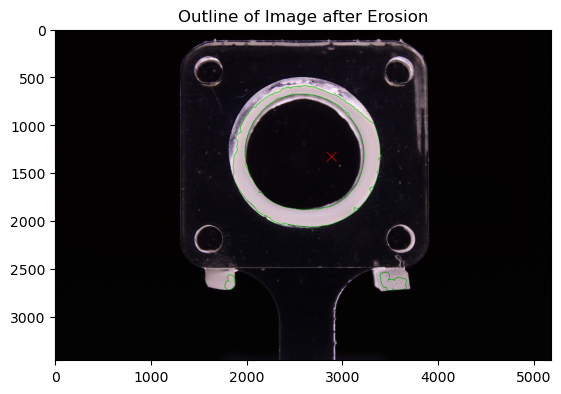

In [266]:
centerLength = 50
cv2.line(outlineMid, (xCenter-centerLength, yCenter-centerLength), (xCenter+centerLength, yCenter+centerLength), (255,0,0), 5)
cv2.line(outlineMid, (xCenter-centerLength, yCenter+centerLength), (xCenter+centerLength, yCenter-centerLength), (255,0,0), 5)
plt.imshow(outlineMid)
plt.title("Outline of Image after Erosion")
plt.show()